# Dataset: Bike Sharing
### (regression task)

## 1. Load Dataset

In [57]:
# import
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt

In [17]:
# 데이터셋 로드하기
dfile = 'data/bikesharing.csv'
data = np.genfromtxt(dfile, delimiter=',')

X = data[:,:-1]
y = data[:,-1:]

dim_x = X.shape[1]

print('X,shape: %s, y.shape: %s'%(X.shape, y.shape))

X,shape: (17379, 14), y.shape: (17379, 1)


In [18]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=None, train_size = 5000, random_state = 42)

scalerX = StandardScaler()  
X_trn = scalerX.fit_transform(X_trn)
X_tst = scalerX.transform(X_tst)

scalerY = StandardScaler()
y_trn = scalerY.fit_transform(y_trn)

In [19]:
# Regression datset 생성 (Tensor)
class RegDataset(Dataset):

    def __init__(self, X, Y):
    
        self.X = X
        self.Y = Y

    def __len__(self):
    
        return len(self.X)

    def __getitem__(self, idx):
    
        x = torch.from_numpy(self.X[idx]).float()
        y = torch.from_numpy(self.Y[idx]).float()
    
        return x, y
    
training_data = RegDataset(X_trn, y_trn)
test_data = RegDataset(X_tst, y_tst)

In [20]:
#Dataloader
trainloader = DataLoader(training_data, batch_size=50, shuffle=True, drop_last=True)
testloader = DataLoader(test_data, batch_size=50, shuffle=False)

## 2. Define a Feedforward Neural Network

In [26]:
# 모델 정의
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(14, 500),
            nn.Tanh(),
            nn.Linear(500, 1),
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

net = NeuralNetwork()

## 3. Define a Loss Function and Optimizer

In [27]:
# hyperparmeter 설정
learning_rate = 1e-3
num_epochs = 10

In [28]:
# loss function 및 optimizer 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

## 4. Train the Network

In [29]:
# 여러 epoch을 반복하며 NN 모델 학습

for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 10 == 0:
            if i > 0:
                print('epoch: %d, iter: %d, loss: %.3f'%((epoch+1), i, running_loss/10))
                running_loss = 0.0

    print('%d epoch processed...'%(epoch+1))

print('Finished Training')

epoch: 1, iter: 10, loss: 0.657
epoch: 1, iter: 20, loss: 0.116
epoch: 1, iter: 30, loss: 0.025
epoch: 1, iter: 40, loss: 0.015
epoch: 1, iter: 50, loss: 0.015
epoch: 1, iter: 60, loss: 0.008
epoch: 1, iter: 70, loss: 0.008
epoch: 1, iter: 80, loss: 0.006
epoch: 1, iter: 90, loss: 0.006
1 epoch processed...
epoch: 2, iter: 10, loss: 0.005
epoch: 2, iter: 20, loss: 0.005
epoch: 2, iter: 30, loss: 0.006
epoch: 2, iter: 40, loss: 0.005
epoch: 2, iter: 50, loss: 0.004
epoch: 2, iter: 60, loss: 0.004
epoch: 2, iter: 70, loss: 0.006
epoch: 2, iter: 80, loss: 0.005
epoch: 2, iter: 90, loss: 0.006
2 epoch processed...
epoch: 3, iter: 10, loss: 0.004
epoch: 3, iter: 20, loss: 0.004
epoch: 3, iter: 30, loss: 0.005
epoch: 3, iter: 40, loss: 0.004
epoch: 3, iter: 50, loss: 0.004
epoch: 3, iter: 60, loss: 0.004
epoch: 3, iter: 70, loss: 0.003
epoch: 3, iter: 80, loss: 0.003
epoch: 3, iter: 90, loss: 0.003
3 epoch processed...
epoch: 4, iter: 10, loss: 0.002
epoch: 4, iter: 20, loss: 0.003
epoch: 4,

In [30]:
# 학습된 모델 저장하기

PATH = './bikesharing_fnnet.pth'
torch.save(net.state_dict(), PATH)

In [31]:
# 저장된 모델의 Parameter 불러오기

net = NeuralNetwork()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 5. Test the Network on the Test Data

In [59]:
# 전체 test set에 대한 accuracy

pred_list = []
labels_list = []

# 모델 학습을 종료하였으므로 gradient 계산을 할 필요가 없음
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        
        # 샘플 데이터 포인트에 대한 model output 출력
        outputs = net(inputs)

        # label 과의 스케일을 맞추기 위한 역스케일링
        outputs = scalerY.inverse_transform(outputs)
        
        # 예측 결과 형태 수정
        pred = np.squeeze(outputs, axis =-1)
        labels = np.squeeze(labels, axis =-1)
        
        pred_list.append(pred)
        labels_list.append(labels)
        

pred_list = np.hstack(pred_list)
labels_list = np.hstack(labels_list)

rmse = mean_squared_error(pred_list, labels_list)**0.5
r2 = r2_score(pred_list, labels_list)
print('RMSE of the network on the test dataset:', rmse)
print('R2 of the network on the test dataset:', r2)

RMSE of the network on the test dataset: 6.149031688562239
R2 of the network on the test dataset: 0.9988399694094672


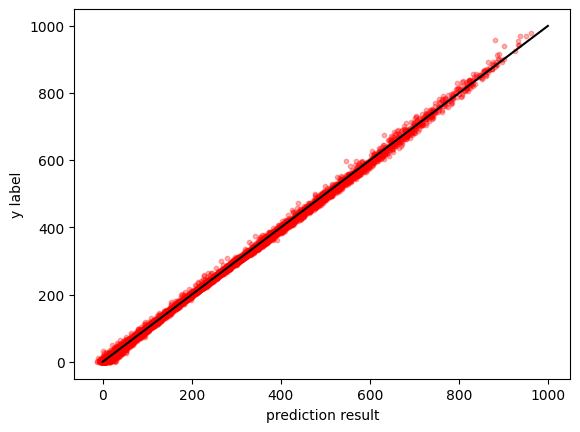

In [60]:
plt.scatter(pred_list, labels_list, c='red', s=10, alpha=0.3)
plt.plot(np.arange(1000), np.arange(1000), c= 'black')
plt.xlabel('prediction result')
plt.ylabel('y label')
plt.show()